In [ ]:
import json
import random
import re
from collections import Counter
import os
import numpy as np
from lingua import Language, LanguageDetectorBuilder
import html
import matplotlib.pyplot as plt
from simhash import Simhash
import hashlib
from tqdm import tqdm

# Inspect json file

In [2]:
def read_jsonl(filepath, n=5):
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= n:
                break
            print(json.loads(line))
            

In [3]:
read_jsonl("mainpipe_data_v1.jsonl")

{'text': 'In the never ending battle to rid Alaska of its Permanent Fund, strange bedfellows from the Alaska corporate community, a famous foundation and leaders from both parties are anxious to convince ordinary Alaskans that tapping the fund must be the first step. It should be the last and only after other sources of revenue are fully explored. As Steve Heimel puts " I agree that a fiscal solution should involve the Permanent Fund earnings, but last, not first. First readjusting the oil tax, other revenue sources, Constitutional Budget Reserve, cuts, and only after those should the Fund\'s earnings be considered. These people are willing to give political cover to the Republicans, who have always hated the Permanent Fund anyway. Is it going to remain the third rail of Alaska politics? Probably".', 'url': None}
{'text': '» Jackpot | Deutsche Online Casinos und Casino Spiele\nBeim MrGreen Casino wurde am zweiten Weihnachtstag vermeldet, dass sich ein glücklicher Spieler beim Mega Fort

###  sample some lines to know the data better

In [4]:
def sample_jsonl(filepath, n=20):
    with open(filepath, "r", encoding="utf-8") as f:
        lines = f.readlines()

    samples = random.sample(lines, n)
    
    print("---- Sampled Rows ----")
    for line in samples:
        print(json.loads(line))
        print("-------------")

sample_jsonl("mainpipe_data_v1.jsonl", n=30)

---- Sampled Rows ----
{'text': 'We will ensure improvement in quality of consumer experience - NCC Boss, Danbatta\n\nWe will ensure improvement in quality of consumer experience – NCC Boss, Danbatta\nThe Executive Vice Chairman of the Nigerian Communications Commission, NCC, Prof. Umar Danbatta has said that the NCC will work harder to improve the quality of service in the telecom sector and by so doing improve the quality of consumer experience. Danbatta stated this yesterday in Funtua, Katsina State at the Consumer Conversation, a forum […]\nWe will ensure improvement in quality of consumer experience – NCC Boss, Danbatta\nThis post was syndicated from Daily Post Nigeria. Click here to read the full text on the original website.\nDo you something awesome to share with the world? Click here to share\nDo you ever have any question about anything you wish to ask and get answer? Click here to ask\nFollow us on twitter @NigeriaTodayNG\nAlso, Like us on facebook\nShare this: Facebook\nTwi

### Statistical summary on data

In [5]:
def quick_stats(filepath, limit=20000):
    key_counts = Counter()
    length_distribution = []
    empty_count = 0
    short_count = 0

    # file size
    file_size_bytes = os.path.getsize(filepath)
    file_size_mb = file_size_bytes / (1024 * 1024)
    file_size_gb = file_size_mb / 1024

    #  Count total lines
    with open(filepath, "r", encoding="utf-8") as f:
        total_lines = sum(1 for _ in f)

    # test randomly drawn samples
    with open(filepath, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= limit: 
                break
            
            try:
                row = json.loads(line)
            except:
                continue #skip malformed rows
            
            key_counts.update(row.keys())
            text = row.get("text", "")
            
            len_txt=len(text)
            length_distribution.append(len_txt)
            if len_txt ==0:
                empty_count += 1
            if len_txt<100:  #short text threshold
                short_count += 1


    print("FILE OVERVIEW")
    print(f"File size: {file_size_mb:.2f} MB ({file_size_gb:.2f} GB)")
    print(f"Total lines in file: {total_lines:,}")
    print(f"Sampled (limit): {min(limit, total_lines):,}")
    print("------------")
    print("\nKEYS")
    print("Most common keys:", key_counts.most_common(10))
    print("------------")
    print("\nTEXT LENGTH STATS")

    arr = np.array(length_distribution)
    print(f"Avg length: {arr.mean():.2f}")
    print(f"Median length: {np.median(arr):.2f}")
    print(f"10th percentile: {np.percentile(arr, 10):.2f}")
    print(f"90th percentile: {np.percentile(arr, 90):.2f}")
    if np.median(arr) > 300 and arr.mean() > 600:
        print("Most entries are multi-paragraph documents (median text size>300).")
        print("Good for LLM pretraining (rich context, natural text).")
    else:
        print("Overall text seems short on average. Many entries may be fragments, comments, or low-quality text.")

    print(f"Max length: {arr.max()}")
    if arr.max() > 20000:
        print("WARNING: Very long entries detected (>> 20,000 chars). These are almost certainly web dumps such as, " )
        print("raw HTML pages,  code dumps / stack traces, JSON logs or config files, full chat transcripts, base64 or encoded junk." )
        print(" These must be  filtered or trim these before LLM pretraining")
    print(f"Min length: {arr.min()}")
    print("------------")
    print("\nNOISE INDICATORS")
    print(f"Empty texts: {empty_count} ({empty_count/len(arr):.2%})")
    short_txt_pct=short_count/len(arr)
    print(f"Short < 100 chars: {short_count} ({short_txt_pct:.2%})")
    if short_txt_pct < 10:
        print("Only a small fraction of trivial/low-value text.  Dataset likely contains substantial natural text, not noise")
    else:
        print("Many very short entries, may contain garbage or low-quality data.")

    print("------------")
    print("\nDone.")


In [6]:
quick_stats("mainpipe_data_v1.jsonl", limit=50000) #269378

FILE OVERVIEW
File size: 439.23 MB (0.43 GB)
Total lines in file: 269,378
Sampled (limit): 50,000
------------

KEYS
Most common keys: [('text', 50000), ('url', 50000)]
------------

TEXT LENGTH STATS
Avg length: 1600.50
Median length: 759.00
10th percentile: 189.00
90th percentile: 3248.00
Most entries are multi-paragraph documents (median text size>300).
Good for LLM pretraining (rich context, natural text).
Max length: 178482
raw HTML pages,  code dumps / stack traces, JSON logs or config files, full chat transcripts, base64 or encoded junk.
 These must be  filtered or trim these before LLM pretraining
Min length: 1
------------

NOISE INDICATORS
Empty texts: 0 (0.00%)
Short < 100 chars: 1891 (3.78%)
Only a small fraction of trivial/low-value text.  Dataset likely contains substantial natural text, not noise
------------

Done.


 Texts significantly shorter than a typical sentence or two (under 100 characters) are generally not effective as standalone training examples for general-purpose LLM pretraining. Data preparation pipelines typically concatenate such short examples or filter them to ensure each training sample contributes meaningfully to the model's learning objectives. 

### See longest documents

In [7]:
def show_longest_docs(path, n=5):
    docs = []
    with open(path) as f:
        for line in f:
            row = json.loads(line)
            text = row.get("text","")
            docs.append((len(text), text))
    docs.sort(reverse=True)
    for i, (l, t) in enumerate(docs[:n], 1):
        print(f"\n=== Longest Doc #{i} ({l} chars) ===\n")
        print(t[:2000])
        print("\n------------------------------------\n")


In [8]:
show_longest_docs("mainpipe_data_v1.jsonl") #178482


=== Longest Doc #1 (372627 chars) ===

function emitFiles(resolver, host, targetSourceFile, emitOnlyDtsFiles) {
        // emit output for the __extends helper function
        var extendsHelper = "\nvar __extends = (this && this.__extends) || function (d, b) {\n    for (var p in b) if (b.hasOwnProperty(p)) d[p] = b[p];\n    function __() { this.constructor = d; }\n    d.prototype = b === null ? Object.create(b) : (__.prototype = b.prototype, new __());\n};";
        var assignHelper = "\nvar __assign = (this && this.__assign) || Object.assign || function(t) {\n    for (var s, i = 1, n = arguments.length; i < n; i++) {\n        s = arguments[i];\n        for (var p in s) if (Object.prototype.hasOwnProperty.call(s, p))\n            t[p] = s[p];\n    }\n    return t;\n};";
        // emit output for the __decorate helper function
        var decorateHelper = "\nvar __decorate = (this && this.__decorate) || function (decorators, target, key, desc) {\n    var c = arguments.length, r = c <

### Show HTML

In [ ]:
# Detects real HTML tags
HTML_TAG_PATTERN = re.compile(r"</?[A-Za-z][A-Za-z0-9]*(\s+[^>]*)?>")

# Detects escaped & entities
HTML_ENTITY_PATTERN = re.compile(r"&[A-Za-z]+;|&#\d+;")

# Detect <script> or <style> blocks
SCRIPT_STYLE_PATTERN = re.compile(r"<(script|style)[\s>]", re.IGNORECASE)

def has_html(text):
    """Return True if text contains any HTML tags, escaped HTML, or script/style blocks."""
    if HTML_TAG_PATTERN.search(text):
        return True
    if HTML_ENTITY_PATTERN.search(text):
        return True
    if SCRIPT_STYLE_PATTERN.search(text):
        return True
    return False


In [ ]:
def show_html_examples(path, n=5):
    shown = 0
    with open(path) as f:
        for line in f:
            if shown >= n:
                break
            row = json.loads(line)
            text = row.get("text","")
            if has_html(text):
                print("\n=== HTML DOC ===\n")
                print(text[:1500])
                print("\n----------------\n")
                shown += 1


In [11]:
show_html_examples("mainpipe_data_v1.jsonl") 


=== HTML DOC ===

<p>Ubuntu 9.10</p>

<p>Silly question time: When the clamav-freshclam service is running, how often is clamav checking for updates? Or do I have to manually run freshclam via a cronjob? </p>

<blockquote>
<p>how often is clamav checking for updates?</p>
</blockquote>
<p>Unless you setup a cronjob it will not check for updates.</p>
<blockquote>
<p>Do I have to manually run freshclam via a cronjob?</p>
</blockquote>
<p>The purpose of a cronjob is to automate the process. You can decide to run it in the following:</p>
<pre><code>/etc/cron.daily
/etc/cron.hourly
/etc/cron.weekly
/etc/cron.monthly 
</code></pre>
<p>I recommend <strong>cron.daily</strong> and set it up via a shell script.</p>
<pre><code>sudo gedit /etc/cron.daily/freshclam.sh
</code></pre>
<p>add the lines:</p>
<pre><code>#!/bin/sh
/usr/bin/freshclam --quiet
</code></pre>
<p>This will now run with all your other cron.daily jobs</p>
<p>Save and exit</p>
<pre><code>sudo chmod 755 /etc/cron.daily/freshclam.sh

### Detect presesence of non-ascii text 
includes non european languages french, hindi, chinese, japanese that does not involve ascii; however, may not include many European languages.

In [12]:
def detect_non_ascii(path, limit=20000):
    non_english = 0
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= limit: 
                break
            text = json.loads(line).get("text", "")
            
            # heuristic for non-English: presence of many non-Latin chars
            if re.search(r"[^\x00-\x7F]+", text):
                non_english += 1

    print(f"Likely non-English: {non_english}/{limit} = {non_english/limit:.2%}")

In [13]:
detect_non_ascii("mainpipe_data_v1.jsonl", limit=269378) ##269378

Likely non-English: 71800/269378 = 26.65%


# Language detection

In [14]:
ALL_LANGUAGES = Language.all()
lang_detector = LanguageDetectorBuilder.from_languages(*ALL_LANGUAGES).build()

def detect_lang(text):
    try:
        lang = lang_detector.detect_language_of(text)
        return lang.iso_code_639_1.name if lang else "UNKNOWN"
    except:
        return "ERROR"

def sample_language_distribution(path, sample_size=5000):
    langs = Counter()
    lines = []

    with open(path, "r", encoding="utf-8") as f:
        lines = random.sample(list(f), sample_size)

    for line in lines:
        row = json.loads(line)
        text = row.get("text", "")
        if not text.strip():
            continue

        lang = detect_lang(text)
        langs[lang] += 1

    return langs

In [15]:
langs = sample_language_distribution("mainpipe_data_v1.jsonl", sample_size=25000)
print(langs)

Counter({'EN': 22879, 'DE': 985, 'ES': 804, 'LA': 160, 'TL': 29, 'YO': 24, 'NN': 15, 'DA': 14, 'NL': 11, 'CY': 10, 'EO': 10, 'MI': 8, 'XH': 6, 'FR': 4, 'SV': 4, 'ZH': 3, 'TS': 3, 'ID': 3, 'IT': 3, 'PT': 3, 'LG': 3, 'TN': 3, 'NB': 2, 'SW': 2, 'ZU': 2, 'GA': 2, 'CA': 1, 'HU': 1, 'UNKNOWN': 1, 'SO': 1, 'RO': 1, 'PL': 1, 'FI': 1, 'AF': 1})


In [16]:
total = sum(langs.values())

for lang, count in langs.items():
    pct = (count / total) * 100
    print(f"{lang}: {pct:.2f}%")

EN: 91.52%
DE: 3.94%
YO: 0.10%
ES: 3.22%
ZH: 0.01%
LA: 0.64%
NL: 0.04%
CY: 0.04%
CA: 0.00%
NN: 0.06%
TL: 0.12%
TS: 0.01%
XH: 0.02%
MI: 0.03%
FR: 0.02%
DA: 0.06%
ID: 0.01%
HU: 0.00%
EO: 0.04%
IT: 0.01%
NB: 0.01%
PT: 0.01%
SW: 0.01%
ZU: 0.01%
SV: 0.02%
GA: 0.01%
LG: 0.01%
TN: 0.01%
UNKNOWN: 0.00%
SO: 0.00%
RO: 0.00%
PL: 0.00%
FI: 0.00%
AF: 0.00%


# code detection

In [17]:
# Strong signal Python code
PATTERN_PYTHON = re.compile(
    r"(^|\n)\s*def\s+\w+\s*\(|(^|\n)\s*return\b"
)

# Strong signal JavaScript/TypeScript
PATTERN_JS = re.compile(
    r"(^|\n)\s*function\s+\w+\s*\("   # function foo(
)

# Strong signal C/C++
PATTERN_CPP = re.compile(
    r"#include\s+<\w+\.h>"  # #include <stdio.h>
)

# Strong signal Rust
PATTERN_RUST = re.compile(
    r"(^|\n)\s*fn\s+\w+\s*\("  # fn main(
)

# Strong signal Java/C#
PATTERN_JAVA = re.compile(
    r"(^|\n)\s*(public|private|protected)\s+\w+\s+\w+\s*\("  # public void main(
)

def is_code_line(line):
    return (
        PATTERN_PYTHON.search(line) or
        PATTERN_JS.search(line) or
        PATTERN_CPP.search(line) or
        PATTERN_RUST.search(line) or
        PATTERN_JAVA.search(line)
    )


def code_fraction(text):
    lines = [l for l in text.splitlines() if l.strip()]
    if not lines:
        return 0.0
    
    code_lines = sum(1 for l in lines if is_code_line(l))
    return code_lines / len(lines)


In [18]:
def sample_code_fraction(path, sample_size=5000):

    with open(path, "r") as f:
        lines = random.sample(list(f), sample_size)

    code_docs = 0
    for line in lines:
        row = json.loads(line)
        text = row.get("text", "")
        if code_fraction(text) > 0.40:
            code_docs += 1

    print(f"Code-heavy (>40% code) docs: {code_docs}/{sample_size} = {code_docs/sample_size:.2%}")


In [19]:
sample_code_fraction("mainpipe_data_v1.jsonl", sample_size=25000)

Code-heavy (>40% code) docs: 298/25000 = 1.19%


In [ ]:
'''
def summarize_dataset(path, sample_size=10000):
    summary = Counter()

    with open(path, "r", encoding="utf-8") as f:
        lines = random.sample(list(f), sample_size)

    for line in lines:
        try:
            row = json.loads(line)
        except:
            summary["MALFORMED"] += 1
            continue

        text = row.get("text", "")
        if not text.strip():
            summary["EMPTY"] += 1
            continue

        # 1. Language detection
        lang = detect_lang(text)
        if lang != "EN":
            summary["NON_ENGLISH"] += 1

        # 2. HTML detection
        if has_html(text):
            summary["HTML"] += 1

        # 3. Code-heavy detection
        if code_fraction(text) > 0.40:
            summary["CODE_HEAVY"] += 1

        # 4. Good documents (strict: EN & no HTML & not code-heavy)
        if (
            lang == "EN"
            and not has_html(text)
            and code_fraction(text) <= 0.40
            and len(text) >= 200
        ):
            summary["GOOD_ENGLISH"] += 1

    return summary
'''

In [21]:
def summarize_dataset(path, sample_size=10000):
    summary = Counter()

    with open(path, "r", encoding="utf-8") as f:
        lines = random.sample(list(f), sample_size)

    for line in lines:
        try:
            row = json.loads(line)
        except:
            summary["MALFORMED"] += 1
            continue

        text = row.get("text", "")
        if not text.strip():
            summary["EMPTY"] += 1
            continue

        # 1. Language detection
        lang = detect_lang(text)
        if lang != "EN":
            summary["NON_ENGLISH"] += 1

        # 2. HTML detection
        if has_html(text):
            summary["HTML"] += 1

        # 3. Code-heavy detection
        if code_fraction(text) > 0.40:
            summary["CODE_HEAVY"] += 1

        # 4. Good English
        if (
            lang == "EN"
            and not has_html(text)
            and code_fraction(text) <= 0.40
            and len(text) >= 200
        ):
            summary["GOOD_ENGLISH"] += 1

    # convert to percentages
    summary_pct = {k: (v / sample_size) * 100 for k, v in summary.items()}

    return summary, summary_pct


In [22]:
summary, summary_pct = summarize_dataset("mainpipe_data_v1.jsonl", sample_size=25000)
print(summary)
print(summary_pct)

Counter({'GOOD_ENGLISH': 14408, 'HTML': 5827, 'NON_ENGLISH': 2116, 'CODE_HEAVY': 334})
{'HTML': 23.308, 'GOOD_ENGLISH': 57.632000000000005, 'NON_ENGLISH': 8.464, 'CODE_HEAVY': 1.336}


In [23]:
57.548+23.844+8.192+1.148

90.732

In [24]:
def plot_summary_percentage(summary_pct, sample_size):
    labels = list(summary_pct.keys())
    values = list(summary_pct.values()) ##[summary[k] / sample_size * 100 for k in labels]

    plt.figure(figsize=(12,6))
    plt.bar(labels, values)
    plt.xticks(rotation=45)
    plt.ylabel("Percentage (%)")
    plt.title("Dataset Quality (percentage)")
    plt.tight_layout()
    plt.show()


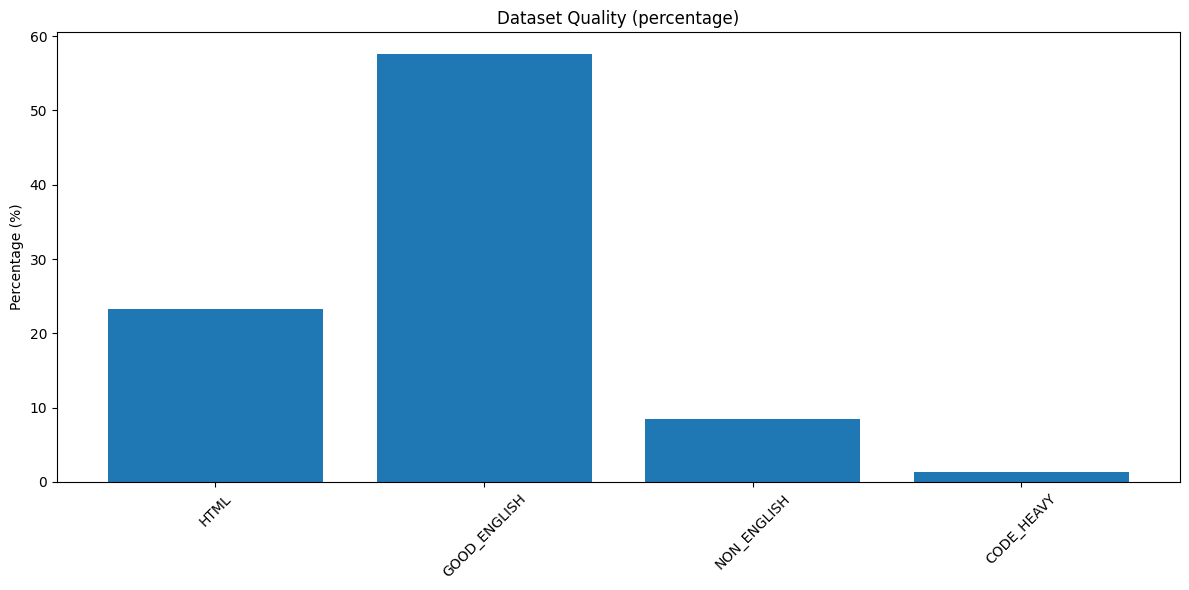

In [25]:

plot_summary_percentage(summary_pct, sample_size=25000)


In [26]:
def classify_doc(text):
    """Return a single category for each document."""
    
    # HTML has highest priority
    if has_html(text):
        return "HTML"
    
    # Code-heavy comes next
    if code_fraction(text) > 0.40:
        return "CODE_HEAVY"
    
    # OTHER Languages
    lang = detect_lang(text)
    if lang != "EN":
        return "NON_ENGLISH_LANG"
    
    # Good English (no HTML, no code, significant length for training, EN) 
    if len(text) >= 200:
        return "GOOD_ENGLISH"
    
    # 5 — fallback
    return "SHORT_ENGLISH"


In [27]:
def summarize_dataset_exclusive(path, sample_size=10000):
    summary = Counter()

    with open(path, "r", encoding="utf-8") as f:
        lines = random.sample(list(f), sample_size)

    for line in lines:
        try:
            row = json.loads(line)
        except:
            summary["MALFORMED"] += 1
            continue

        text = row.get("text", "").strip()
        if not text:
            summary["EMPTY"] += 1
            continue

        category = classify_doc(text)
        summary[category] += 1

    # Convert to percentages
    summary_pct = {k: v / sample_size * 100 for k, v in summary.items()}

    return summary, summary_pct


In [28]:
summary_counts, summary_pct = summarize_dataset_exclusive(
    "mainpipe_data_v1.jsonl",
    sample_size=25000 #269378    # 269378  25000
)

print(summary_counts)
print(summary_pct)


Counter({'GOOD_ENGLISH': 14348, 'HTML': 5956, 'SHORT_ENGLISH': 2330, 'NON_ENGLISH_LANG': 2066, 'CODE_HEAVY': 300})
{'HTML': 23.824, 'SHORT_ENGLISH': 9.32, 'GOOD_ENGLISH': 57.391999999999996, 'NON_ENGLISH_LANG': 8.264000000000001, 'CODE_HEAVY': 1.2}


In [29]:
23.74692810845726+57.45235319885068+1.216877399045208+8.128354951035348+9.455486342611499

99.99999999999999

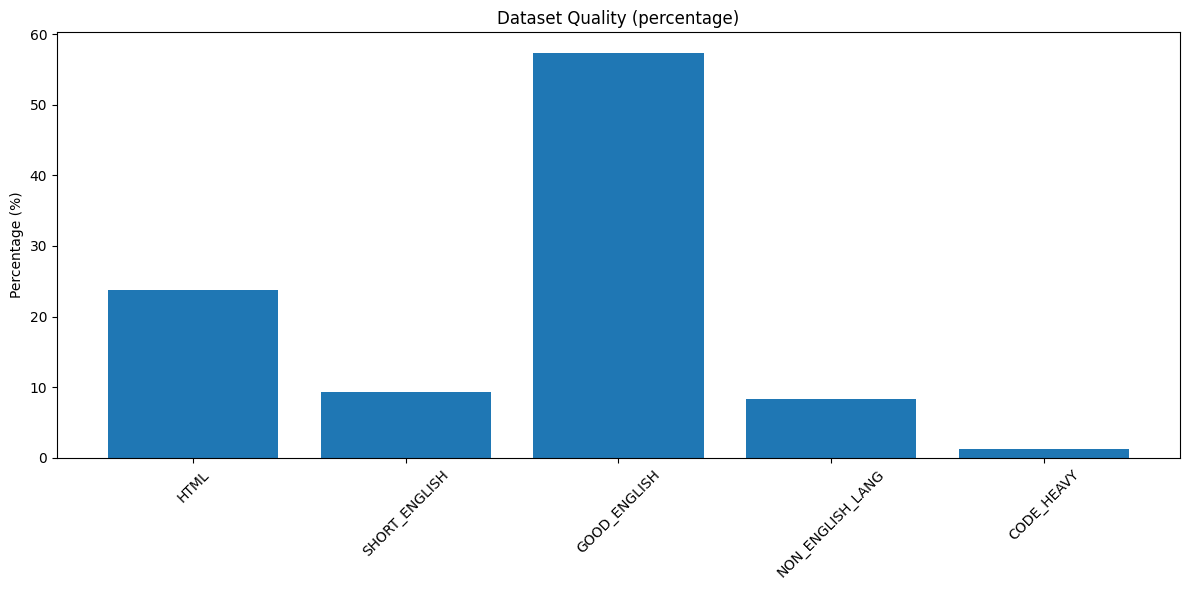

In [30]:
plot_summary_percentage(summary_pct, sample_size=269378) #269378  25000

plt.savefig("figures/summary_percentage.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.close()

# Cleaning

### Remove Duplication

In [ ]:


def hash_text(text):
    """Return a stable hash (sha256) of a string."""
    return hashlib.sha256(text.encode("utf-8")).hexdigest()


def dedup_exact(input_path, output_path):
    seen = set()
    kept = 0
    dropped = 0

    with open(input_path, "r", encoding="utf-8") as fin, \
         open(output_path, "w", encoding="utf-8") as fout:

        for line in fin:
            try:
                row = json.loads(line)
            except:
                continue

            text = row.get("text", "")
            h = hash_text(text)

            if h in seen:
                dropped += 1
                continue

            seen.add(h)
            kept += 1
            fout.write(json.dumps(row) + "\n")

    print(f"Exact dedup done: kept={kept:,}, dropped={dropped:,}")


In [ ]:
dedup_exact("mainpipe_data_v1.jsonl", "mainpipe_data_deduplicated.jsonl")

Exact dedup done: kept=220,896, dropped=48,482


### html stripping

In [33]:
def strip_html(text):
    # Remove script/style
    text = re.sub(
        r"<script.*?>.*?</script>|<style.*?>.*?</style>",
        " ", text, flags=re.DOTALL | re.IGNORECASE
    )

    # Remove comments
    text = re.sub(r"<!--.*?-->", " ", text, flags=re.DOTALL)

    # Remove tags
    text = re.sub(r"</?[A-Za-z][A-Za-z0-9]*(\s+[^>]*)?>", " ", text)

    # Decode entities
    text = html.unescape(text)

    # Collapse whitespace
    text = re.sub(r"\s+", " ", text)
    return text.strip()


### normalization

In [34]:
def normalize_text(text):
    text = re.sub(r"[\u200B-\u200D\uFEFF]", "", text)
    text = text.replace("\u00A0", " ")
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [35]:
def stream_jsonl(path):
    """Yield each JSON object from a JSONL file."""
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except:
                continue

def write_jsonl(path, row):
    """Append a single JSON object as a JSONL line."""
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

# Cleaning pipeline

In [36]:
'''
def clean_dataset(input_path, output_path):
    print("\n=== RUNNING CLEANING PIPELINE ===")
    counters = Counter()

    with open(output_path, "w", encoding="utf-8") as fout:

        for row in tqdm(stream_jsonl(input_path)):
            try:
                text = row.get("text", "").strip()
            except:
                counters["MALFORMED"] += 1
                continue

            # 1. Empty or malformed
            if not text:
                counters["EMPTY"] += 1
                continue

            # 2. HTML stripping
            if has_html(text):
                counters["HTML_STRIPPED"] += 1
                text = strip_html(text)

            # 3. Language filter
            lang = detect_lang(text)
            if lang != "EN":
                counters["NON_ENGLISH"] += 1
                continue

            # 4. Code-heavy filter
            if code_fraction(text) > 0.40:
                counters["CODE_HEAVY"] += 1
                continue

            # 5. Length filtering
            L = len(text)
            if L < 200:
                counters["TOO_SHORT"] += 1
                continue
            if L > 50000:
                counters["TOO_LONG"] += 1
                continue

            # 6. Normalize
            text = normalize_text(text)

            fout.write(json.dumps({"text": text}) + "\n")
            counters["KEPT"] += 1

    print("\n=== CLEANING FINISHED ===")
    for k, v in counters.items():
        print(f"{k}: {v:,}")

    return counters

clean_dataset( "mainpipe_data_deduplicated.jsonl",  "mainpipe_clean_data.jsonl")
'''

'\ndef clean_dataset(input_path, output_path):\n    print("\n=== RUNNING CLEANING PIPELINE ===")\n    counters = Counter()\n\n    with open(output_path, "w", encoding="utf-8") as fout:\n\n        for row in tqdm(stream_jsonl(input_path)):\n            try:\n                text = row.get("text", "").strip()\n            except:\n                counters["MALFORMED"] += 1\n                continue\n\n            # 1. Empty or malformed\n            if not text:\n                counters["EMPTY"] += 1\n                continue\n\n            # 2. HTML stripping\n            if has_html(text):\n                counters["HTML_STRIPPED"] += 1\n                text = strip_html(text)\n\n            # 3. Language filter\n            lang = detect_lang(text)\n            if lang != "EN":\n                counters["NON_ENGLISH"] += 1\n                continue\n\n            # 4. Code-heavy filter\n            if code_fraction(text) > 0.40:\n                counters["CODE_HEAVY"] += 1\n         

In [37]:
def clean_dataset(input_path, output_path, verbose=True):

    if verbose:
        print("\n=== RUNNING CLEANING PIPELINE ===")

    counters = Counter()

    with open(output_path, "w", encoding="utf-8") as fout:
        for row in tqdm(stream_jsonl(input_path)):
            try:
                text = row.get("text", "").strip()
            except:
                counters["MALFORMED"] += 1
                continue

            # 1. Empty
            if not text:
                counters["EMPTY"] += 1
                continue

            # 2. Strip HTML
            if has_html(text):
                counters["HTML_STRIPPED"] += 1
                text = strip_html(text)

            # 3. Language detection
            lang = detect_lang(text)
            if lang != "EN":
                counters["NON_ENGLISH"] += 1
                continue

            # 4. Code-heavy filtering
            if code_fraction(text) > 0.40:
                counters["CODE_HEAVY"] += 1
                continue

            # 5. Length rules
            L = len(text)
            if L < 200:
                counters["TOO_SHORT"] += 1
                continue
            if L > 50000:
                counters["TOO_LONG"] += 1
                continue

            # 6. Normalize
            text = normalize_text(text)

            # Save cleaned doc
            fout.write(json.dumps({"text": text}) + "\n")
            counters["KEPT"] += 1

    if verbose:
        print("\n=== CLEANING FINISHED ===")
        for k, v in counters.items():
            print(f"{k}: {v:,}")

    return counters


In [38]:
def plot_cleaning_report(counters, title="Cleaning Report"):
    labels = list(counters.keys())
    values = [counters[k] for k in labels]

    plt.figure(figsize=(12,5))
    plt.bar(labels, values)
    plt.xticks(rotation=45)
    plt.ylabel("Document Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_cleaning_summary(counters):
    print("\n========== CLEANING SUMMARY ==========")
    total = sum(counters.values())

    # Explicitly print removals first
    removal_keys = [
        "EMPTY", "HTML_STRIPPED", "NON_ENGLISH", "CODE_HEAVY",
        "TOO_SHORT", "TOO_LONG", "MALFORMED"
    ]
    keep_key = "KEPT"

    for k in removal_keys:
        if k in counters:
            print(f"{k:15}: {counters[k]:6}  ({counters[k]/total*100:6.2f}%)")

    if keep_key in counters:
        print(f"{keep_key:15}: {counters[keep_key]:6}  ({counters[keep_key]/total*100:6.2f}%)")

    print("======================================\n")


In [39]:
c= clean_dataset( "mainpipe_data_deduplicated.jsonl",  "mainpipe_clean_data2.jsonl")


=== RUNNING CLEANING PIPELINE ===


220896it [06:07, 601.59it/s]


=== CLEANING FINISHED ===
KEPT: 173,940
NON_ENGLISH: 21,200
HTML_STRIPPED: 53,294
TOO_SHORT: 23,301
CODE_HEAVY: 2,158
TOO_LONG: 297



========== CLEANING SUMMARY ==========
HTML_STRIPPED  :  53294  ( 19.44%)
NON_ENGLISH    :  21200  (  7.73%)
CODE_HEAVY     :   2158  (  0.79%)
TOO_SHORT      :  23301  (  8.50%)
TOO_LONG       :    297  (  0.11%)
KEPT           : 173940  ( 63.44%)



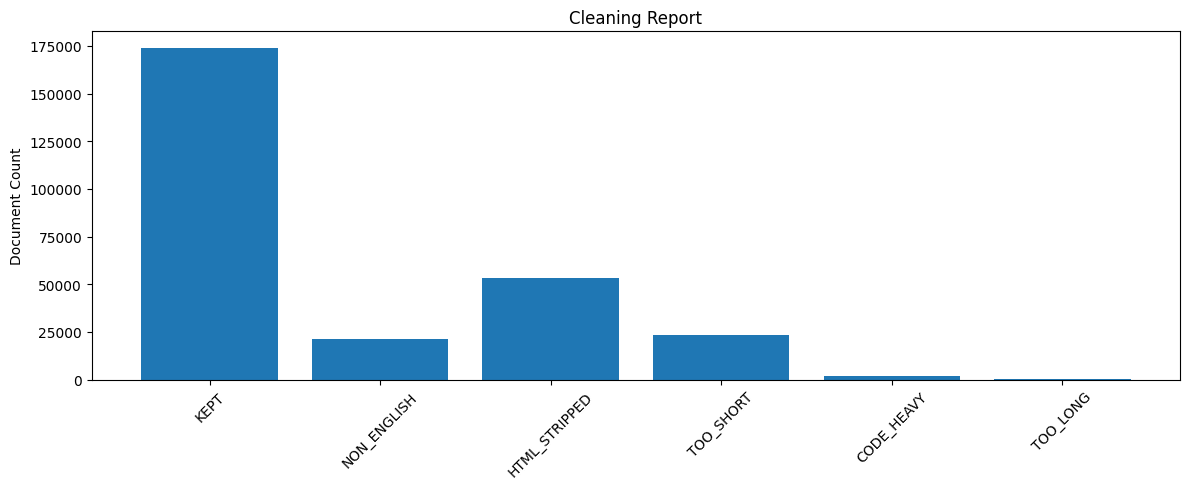

In [40]:
print_cleaning_summary(c)
plot_cleaning_report(c)

### Near Deduplicates

In [41]:
'''
def simhash_text(text):
    return Simhash(text.split()).value   # 64-bit integer
def dedup_near(input_path, output_path, hamming_threshold=3):
    signatures = []
    kept = 0
    dropped = 0

    with open(input_path, "r") as fin, \
         open(output_path, "w") as fout:

        for line in fin:
            row = json.loads(line)
            text = row.get("text", "")

            sig = Simhash(text.split()).value

            # Compare with existing signatures
            is_duplicate = False
            for prev_sig in signatures:
                if bin(sig ^ prev_sig).count("1") <= hamming_threshold:
                    is_duplicate = True
                    break

            if is_duplicate:
                dropped += 1
                continue
            
            signatures.append(sig)
            kept += 1
            fout.write(json.dumps(row) + "\n")

    print(f"Near-dedup: kept={kept:,}, dropped={dropped:,}")
    
dedup_near( "mainpipe_data_deduplicated.jsonl",  "mainpipe_data_sim_deduplicated.jsonl")

'''

'\ndef simhash_text(text):\n    return Simhash(text.split()).value   # 64-bit integer\ndef dedup_near(input_path, output_path, hamming_threshold=3):\n    signatures = []\n    kept = 0\n    dropped = 0\n\n    with open(input_path, "r") as fin,          open(output_path, "w") as fout:\n\n        for line in fin:\n            row = json.loads(line)\n            text = row.get("text", "")\n\n            sig = Simhash(text.split()).value\n\n            # Compare with existing signatures\n            is_duplicate = False\n            for prev_sig in signatures:\n                if bin(sig ^ prev_sig).count("1") <= hamming_threshold:\n                    is_duplicate = True\n                    break\n\n            if is_duplicate:\n                dropped += 1\n                continue\n\n            signatures.append(sig)\n            kept += 1\n            fout.write(json.dumps(row) + "\n")\n\n    print(f"Near-dedup: kept={kept:,}, dropped={dropped:,}")\n\ndedup_near( "mainpipe_data_dedupl

Alternate way to do above is using SentenceTransformer embeddings + ANN; however for current dataset it is not required.

### Note : Repeat deduplication after cleaning